In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import random
from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D 

In [75]:
def draw():
        value = random.randint(1, 10)
        color = ("R" if random.uniform(0, 1) <= 1/3 else "B")
        return value, color

In [76]:
def checkscore(value, color, current_score):
        if color == "B":
            new_score = current_score + value 
        else:
            new_score = current_score - value 
        return new_score

In [77]:
def bustout(score):
        return ((score > 21) or (score < 1))

In [78]:
class Easy21():
    def __init__(self):
        pscore, _ = draw()
        dscore, _ = draw()
        self.state = {"dealer": dscore, "player": pscore}
        self.actions = ("hit","stick")
        init_state = self.state.copy()
        self.h = [init_state]
    def step(self, state,action):
        self.h.append({"Player":action})
        
        if action == 'hit':
            num , color = draw()
            self.state['player'] = checkscore(num, color, current_score = self.state['player'])
            new_state = self.state.copy()
            
            if bustout(self.state['player']):
                reward = -1
                state = "terminal"
                self.h.append(state)
                return state, reward
            
            else:
                reward = 0
                self.h.append(new_state)
                return self.state, reward
        else:
            new_state = self.state.copy()
            self.h.append(new_state)
            
            state, reward = self.dealerplay()
            return state, reward
    def dealerplay(self): 
        # dealer hits as long as his score is < 17
        while self.state['dealer'] < 17:
            v, c = draw()
            new_dealer_score = checkscore(v, c, current_score = self.state['dealer'])
            self.state['dealer'] = new_dealer_score
            
            new_state = self.state.copy()
            self.h.append({"dealer": "hit"})
            self.h.append(new_state)
            
            
            if bustout(new_dealer_score):
                # dealer goes bust, player wins
                reward = 1
                state = "terminal"
                self.h.append(state)
                return state, reward
            
        self.h.append({"dealer": "stick"})  
        
        pscore = self.state['player']
        dscore = self.state['dealer']  
        
        # score > 17 -> dealer sticks
        state = "terminal"
        self.h.append(state)
        if dscore < pscore: # player wins
            reward = 1
            return state, reward                    
        if dscore == pscore: # draw
            reward = 0
            return state, reward                 
        if dscore > pscore: # player loses
            reward = -1
            return state, reward
            

In [81]:
easy21_game = Easy21()
state_0 = easy21_game.state
state_1 = easy21_game.step(state_0, "hit")[0]
state_2 = easy21_game.step(state=state_1, action="stick")
easy21_game.h

[{'dealer': 1, 'player': 9},
 {'Player': 'hit'},
 {'dealer': 1, 'player': 11},
 {'Player': 'stick'},
 {'dealer': 1, 'player': 11},
 {'dealer': 'hit'},
 {'dealer': -4, 'player': 11},
 'terminal']

In [86]:
class MC_Control():
    
    def __init__(self, N_0, n_episodes):
        self.actions = ("hit", "stick") 
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior when starting to learn)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        
        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy
 

    def learn_q_value_function(self):
        """
        Update the Q function until optimal value function is reached.
        
        Returns
        ----------
        Q : {state: (action)}, Q value for every state-action pair
        """
        for i in range(self.n_episodes):
            episode = self.play_episode() # run an episode using current policy
            self.policy = "e_greedy"      # policy switch from random to epsilon greedy
            for step in episode: 
                state, action, reward = step
                self.increment_counter(state, action) # increment state-action counter 
                self.update_Q(state, action, reward)  # update the Q value
                
        return self.Q 
                
    def init_to_zeros(self):
        """
        Init the Q function and the incremental counter N at 0 for every state-action pairs.
        
        Returns
        ----------
        lookup_table : {state: (action)}, a dictionnary of states as keys and actions as value
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table
        
    
    def play_episode(self):
        """
        Run a complete (from the initial state to the terminal state) Easy21 game sequence given a policy. 
        
        Returns
        ----------
        episode : [(state, action, reward)], a list of (statec, action, reward)
        """
        easy21_game = Easy21()           # init a game sequence
        state = easy21_game.state.copy() # init state
        episode = []                     # list of the steps of the game sequence
        while state != "terminal":      
            # pick an action regarding the current state and policy
            if self.policy == "random":
                action = self.random_policy()
            if self.policy == "e_greedy":
                action = self.e_greedy_policy(state)
            next_state, reward = deepcopy(easy21_game.step(state, action))
            step = (state, action, reward)
            state = next_state
            episode.append(step)   
            
        return episode
 
    def update_Q(self, state, action, reward):
        """
        Update Q value towards the error term. 
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        reward : int, the current score
        """
        lookup_state = (state["dealer"], state["player"])
        
        # The learning rate, decaying regarding the number of times an action-state pair 
        # has been explored. It scale the amount of modification we want to bring to 
        # the Q value function.
        alpha_t = 1 / self.get_state_action_counter(state, action)
        
        # We adjust the Q value towards the reality (observed) minus what we estimated.
        # This term is usually descrived as the error term.
        self.Q[lookup_state][action] += alpha_t * (reward - self.Q[lookup_state][action]) 
        
        return None

    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer"], state["player"])
        self.N[lookup_state][action] += 1        
        return None
    
    def random_policy(self):
        """
        Return an action follwing a random policy (state free).
        
        Returns
        ----------
        action : string, random action
        """
        action = random.choice(self.actions)
        
        return action
     
     
    def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy (state based).  
        
        Parameters
        ----------
        state : state, state where we pick the action
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        e = self.N_0/(self.N_0 + self.get_state_counter(state))
        if e > random.uniform(0, 1): 
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
            
        return action
    
    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q value at a given state.
        
        Parameters
        ----------
        state : state, state 
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        lookup_state = (state["dealer"], state["player"])
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action
    
    def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Parameters
        ----------
        state : state, state 
        
        Returns
        ----------
        counter : int, the number of times a state as been explored
        """
        lookup_state = (state["dealer"], state["player"])
        counter = np.sum(list(self.N[lookup_state].values()))  
        
        return counter
    
    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Parameters
        ----------
        state : state 
        action : string
        
        Returns
        ----------
        counter : int, the number of times an action-state pair as been explored
        """
        lookup_state = (state["dealer"], state["player"])
        counter = self.N[lookup_state][action]
        
        return counter

In [88]:
def plot_Q(n_episodes):
    mc = MC_Control(N_0=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    # Make data.
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)

    max_Q = np.ndarray(shape=(21, 10))
    for state in mc.Q:
        max_Q[state[1]-1][state[0]-1] = max(mc.Q[state].values())


    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, max_Q, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Optimal Q value function', fontsize=16)
    
    plt.xticks(np.arange(1, 11))
    plt.yticks(np.arange(1, 22))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    

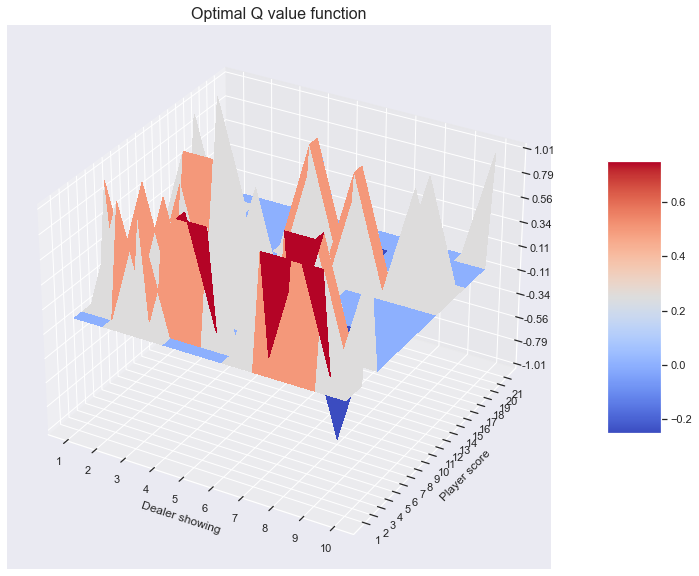

In [89]:

plot_Q(n_episodes=100)

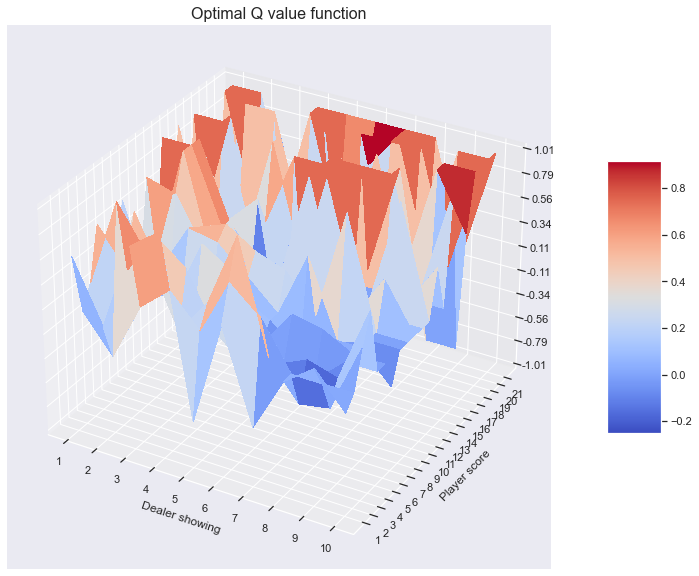

In [90]:
plot_Q(n_episodes=1000)


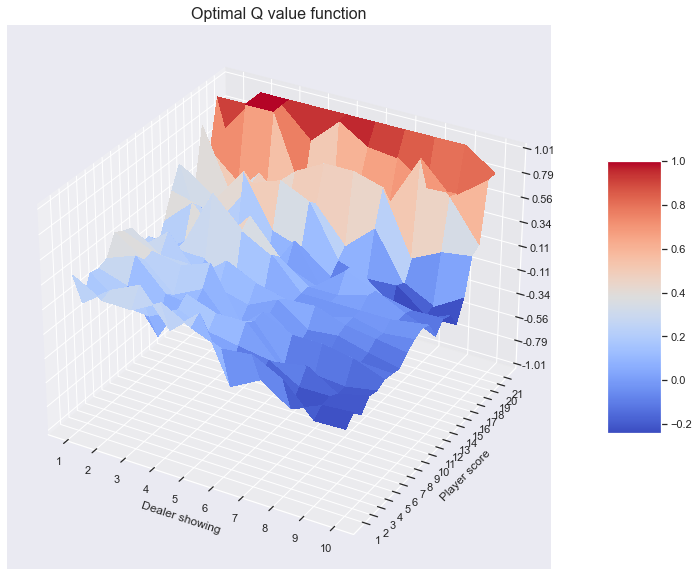

In [91]:
plot_Q(n_episodes=10000)


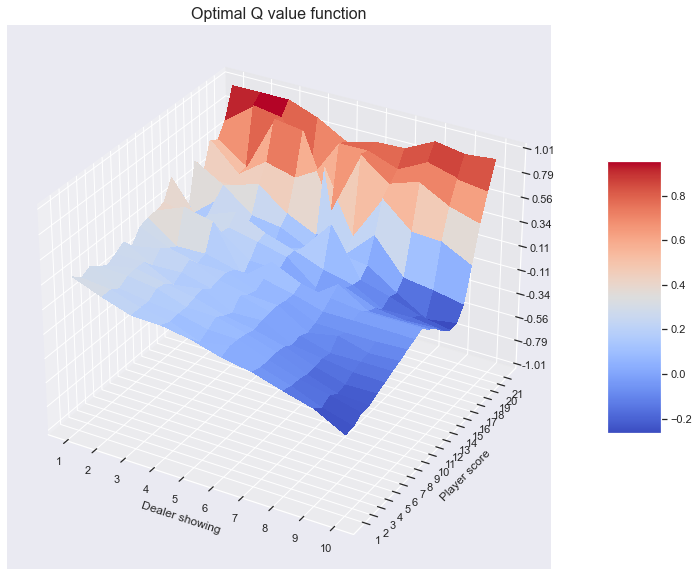

In [92]:
plot_Q(n_episodes=100_000)


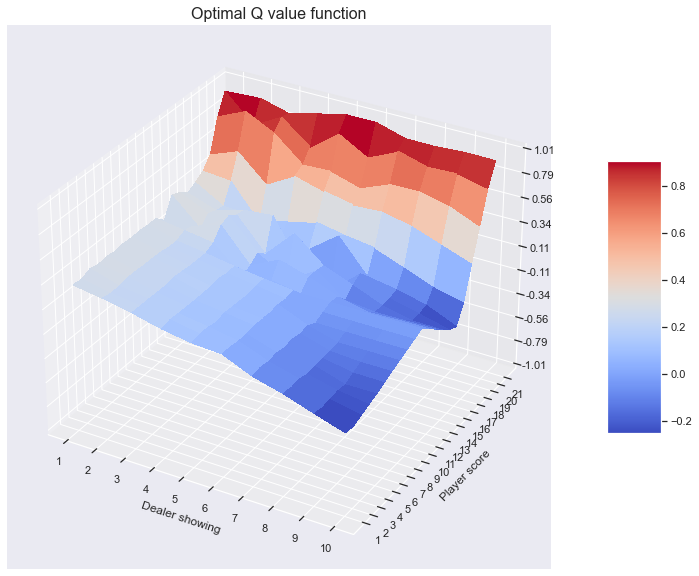

In [93]:
plot_Q(n_episodes=1_000_000)


In [94]:
def plot_opt_policy(n_episodes):
    mc = MC_Control(N_0=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = list(mc.Q.keys())
    for i in range(len(states)):
        best_action = max(mc.Q[states[i]], key=mc.Q[states[i]].get)
        df.loc[i] = (states[i][0], states[i][1], best_action)

    df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
    return df_pivot
    


In [95]:

df = plot_opt_policy(n_episodes=1000)
df


dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,hit,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,hit,hit,hit,hit,hit
3,stick,hit,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,hit,hit,hit,hit,hit
5,stick,stick,hit,stick,stick,stick,hit,stick,hit,hit
6,stick,stick,hit,stick,hit,stick,stick,stick,hit,hit
7,stick,stick,stick,stick,hit,stick,stick,hit,hit,stick
8,stick,stick,stick,stick,hit,stick,stick,stick,stick,stick
9,stick,stick,hit,stick,hit,stick,stick,hit,stick,hit


In [99]:
class SARSA():
    
    def __init__(self, lamb, n_episodes, N_0=100):
        self.actions = ("hit", "stick") 
        self.lamb = lamb                # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior when starting to learn)
        
        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init the counter traces to zeros
        
        # used for plot
        self.Q_history = {} 
        self.list_n_episodes = np.linspace(10, n_episodes-1, 30, dtype=int)

    def learn_q_value_function(self):
        """
        Update the Q function until optimal value function is reached.
        
        Returns
        ----------
        Q : {state: (action)}, Q value for every state-action pair
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros
            easy21_game = Easy21()                           # init a game sequence
            state = easy21_game.state.copy()                 # init state    
            action = self.e_greedy_policy(state)             # pick a first action
            self.increment_counter(state, action)
            
            while state != "terminal":      
                next_state, reward = deepcopy(easy21_game.step(state, action))
                
                if next_state == "terminal":
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    
                else:   
                    next_action = self.e_greedy_policy(next_state)   
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    self.increment_counter(next_state, next_action)
                                                

                self.increment_eligibility_traces(state, action)
                self.update_step(delta)
                
                action = next_action
                state = next_state

            
            if i in self.list_n_episodes: 
                self.Q_history[i] = deepcopy(self.Q)
            
        return self.Q 
                
    def init_to_zeros(self):
        """
        Init the Q function and the incremental counter N at 0 for every state-action pairs.
        
        Returns
        ----------
        lookup_table : {state: (action)}, a dictionnary of states as keys and actions as value
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table
 
    def update_step(self, delta):
        """
        Update the Q value towards the error term and eligibility traces . 
        
        Parameters
        ----------
        delta : float, the delta factor of the current state-action pair
        """
        for state in self.Q.keys():
            for action in self.actions:
                alpha = 1 / (self.get_state_action_counter(state, action) + 1)
                self.Q[state][action] += alpha * delta * self.eligibilty_traces[state][action]
                # Here is where the lambda parameter intervene. The higher, the longer the eligibility trace
                # associated to a state-action pair will remain 
                self.eligibilty_traces[state][action] *= self.lamb
        return None
    
    def compute_delta(self, state, action, next_state, next_action, reward):
        """
        Update Q value towards the error term, it is the TD learning step. 
        
        Parameters
        ----------
        state : state, the current state
        action : string, the current action
        reward : int, the current score
        next_state : int, the state we end after taking the action
        next_action : int, the action we take in next state following the policy (e greedy)
        
        Returns
        ----------
        delta : float, the TD error term
        """
        lookup_state = (state["dealer"], state["player"])
        if next_state == "terminal":
            delta = reward - self.Q[lookup_state][action]
        else:
            next_lookup_state = (next_state["dealer"], next_state["player"])
            delta = reward + self.Q[next_lookup_state][next_action] - self.Q[lookup_state][action]
        return delta

    def increment_eligibility_traces(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer"], state["player"])
        self.eligibilty_traces[lookup_state][action] += 1  
        #print(f"ET counter for state: {lookup_state} and action: {action} --> ", self.N[lookup_state][action])
        return None
    
    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer"], state["player"])
        self.N[lookup_state][action] += 1 
        #print(f"Counter for state: {lookup_state} and action: {action} --> ", self.N[lookup_state][action])
        return None    
    
    def random_policy(self):
        """
        Return an action follwing a random policy (state free).
        
        Returns
        ----------
        action : string, random action
        """
        action = random.choice(self.actions)
        
        return action
          
    def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy (state based).  
        
        Parameters
        ----------
        state : state, state where we pick the action
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        e = self.N_0/(self.N_0 + self.get_state_counter(state))
        if e > random.uniform(0, 1): 
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
            
        return action
    
    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q value at a given state.
        
        Parameters
        ----------
        state : state, state 
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        lookup_state = (state["dealer"], state["player"])
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action
    
    def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Parameters
        ----------
        state : state, state 
        
        Returns
        ----------
        counter : int, the number of times a state as been explored
        """
        lookup_state = (state["dealer"], state["player"])
        counter = np.sum(list(self.N[lookup_state].values()))  
        
        return counter
    
    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Parameters
        ----------
        state : state 
        action : string
        
        Returns
        ----------
        counter : int, the number of times an action-state pair as been explored
        """
        #print(state)
        #lookup_state = (state["dealer_score"], state["player_score"])
        counter = self.N[state][action]
        
        return counter        


In [100]:
sarsa = SARSA(lamb=0.9, n_episodes=100, N_0=100)
sarsa.learn_q_value_function()

{(1, 1): {'hit': -0.372875, 'stick': 0.0},
 (2, 1): {'hit': -0.36450000000000005, 'stick': 0.5},
 (3, 1): {'hit': 0.0, 'stick': 0.0},
 (4, 1): {'hit': 0.45, 'stick': 0.0},
 (5, 1): {'hit': -0.45, 'stick': 0.0},
 (6, 1): {'hit': 0.0, 'stick': 0.0},
 (7, 1): {'hit': 0.0, 'stick': 0.0},
 (8, 1): {'hit': -0.45, 'stick': -0.6666666666666666},
 (9, 1): {'hit': -0.5, 'stick': -0.5},
 (10, 1): {'hit': -0.43000000000000005, 'stick': 0.0},
 (1, 2): {'hit': 0.20312499999999997, 'stick': 0.6666666666666666},
 (2, 2): {'hit': 0.45, 'stick': 0.5},
 (3, 2): {'hit': 0.0, 'stick': 0.0},
 (4, 2): {'hit': -0.68875, 'stick': 0.0},
 (5, 2): {'hit': -0.5, 'stick': 0.0},
 (6, 2): {'hit': 0.0, 'stick': -0.5},
 (7, 2): {'hit': -0.6333333333333333, 'stick': 0.0},
 (8, 2): {'hit': 0.0, 'stick': 0.0},
 (9, 2): {'hit': 0.0, 'stick': -0.5},
 (10, 2): {'hit': 0.0, 'stick': 0.0},
 (1, 3): {'hit': 0.0, 'stick': -0.5},
 (2, 3): {'hit': -0.1365033333333333, 'stick': 0.0},
 (3, 3): {'hit': 0.0, 'stick': 0.0},
 (4, 3): {'

In [101]:
def MSE(optimal_Q, sarsa_Q):
    actions = ["hit", "stick"]
    mse = 0
    for state in optimal_Q.keys():
        for action in actions:
            mse += (sarsa_Q[state][action] - optimal_Q[state][action])**2       
    mse *= (1 / len(action)*len(optimal_Q.keys()))
    return mse

In [102]:
def plot_mse(optimal_Q, n_episodes, list_lambdas):
    df = pd.DataFrame(columns=["mse", "n_episodes", "lambda"])
    #list_lambdas = np.linspace(0,1,11)
    i=0

    for lamb in list_lambdas:
        sarsa_Q = SARSA(lamb=lamb, n_episodes=n_episodes, N_0=100)
        sarsa_Q.learn_q_value_function()
        list_n_episodes = sarsa_Q.list_n_episodes

        for n_episodes in list_n_episodes:
            mse = MSE(optimal_Q, sarsa_Q.Q_history[n_episodes])        
            lamb = round(lamb, 2)
            df.loc[i] = (mse, int(n_episodes), f"lambda = {lamb}")
            i+=1

    fig_dims = (12, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.lineplot(x="n_episodes", y="mse", hue="lambda", data=df)
        

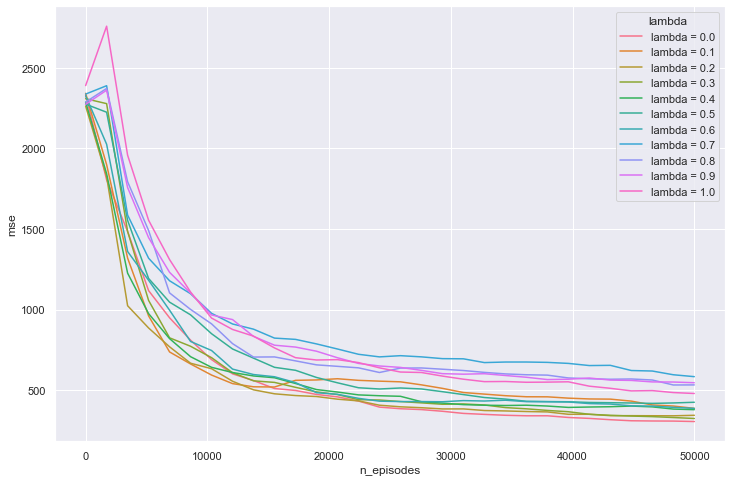

In [103]:
mc = MC_Control(N_0=100, n_episodes=1_000_000)
optimal_Q = mc.learn_q_value_function()

list_lambdas = np.linspace(0, 1, 11)
n_episodes = 50_000
plot_mse(optimal_Q, n_episodes=n_episodes, list_lambdas=list_lambdas)

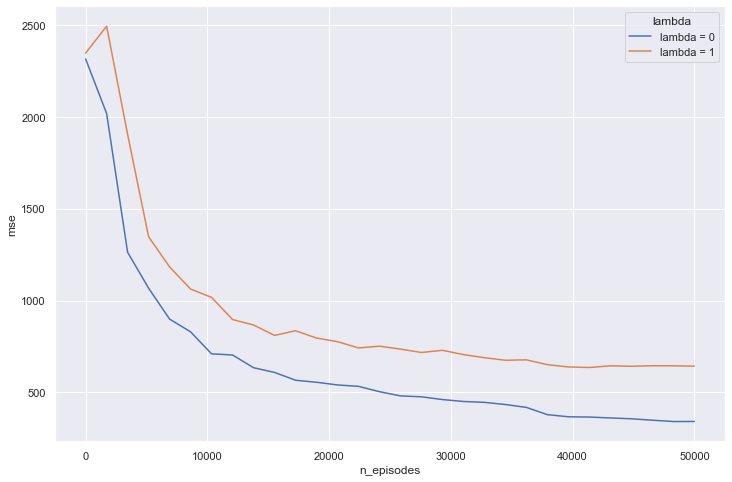

In [104]:
list_lambdas = [0, 1]
n_episodes = 50_000
plot_mse(optimal_Q, n_episodes=n_episodes, list_lambdas=list_lambdas)

In [105]:
def plot_opt_policy(lamb, n_episodes):
    sarsa_Q = SARSA(lamb=lamb, n_episodes=n_episodes, N_0=100)
    sarsa_Q.learn_q_value_function()
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = list(sarsa_Q.Q.keys())
    for i in range(len(states)):
        best_action = max(sarsa_Q.Q[states[i]], key=sarsa_Q.Q[states[i]].get)
        df.loc[i] = (states[i][0], states[i][1], best_action)

    df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
    return df_pivot

plot_opt_policy(lamb=0, n_episodes=50_000)


dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
8,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
9,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit


In [106]:
plot_opt_policy(lamb=0,n_episodes=100_000)


dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,stick,hit,stick
8,stick,stick,stick,stick,hit,stick,stick,stick,stick,stick
9,stick,stick,stick,stick,hit,stick,stick,hit,stick,stick
